# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization, LSTM

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [6]:
# your code here

words = sorted(data['Word'].unique())
words.append('ENDPAD')
n_words = len(words)
words[-20:]

['zeros',
 'zidovudine',
 'zinc',
 'zone',
 'zones',
 'zoo',
 'zookeepers',
 'zoological',
 'zu',
 'zydeco',
 '\x85',
 '\x91',
 '\x92',
 '\x92s',
 '\x93',
 '\x94',
 '\x96',
 '\x97',
 '°C',
 'ENDPAD']

In [7]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [8]:
# your code here

tags = sorted(data['Tag'].unique())
tags.append('PAD')
n_tags = len(tags)
tags

['B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O',
 'PAD']

In [9]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [10]:
# your code here

def wordtag(data):
    return [x for x in zip(data['Word'], data['Tag'])]
sentence = data.groupby('Sentence #').apply(wordtag)

In [11]:
# list of (word,tag) tuples for the first sentence
sentence[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [12]:
# your code here

max_len = max([len(s) for s in sentence])

In [13]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [14]:
# your code here

word2idx = dict()
idx2word = dict()
for idx, word in enumerate(words): 
    word2idx[word] = idx 
    idx2word[idx] = word

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [15]:
# your code here

X = []
for s in sentence:
    inner_list = [] #inner list is a sequence of words in each sentence
    for word in s:
        idx = word2idx[word[0]]
        inner_list.append(idx)
    X.append(inner_list)

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [16]:
# your code here

X = pad_sequences(X, maxlen=max_len ,padding='post',value=word2idx['ENDPAD'])

In [17]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [18]:
# your code here

tag2idx= dict()
idx2tag = dict()
for idx, tag in enumerate(tags):
    tag2idx[tag] = idx
    idx2tag[idx] = tag

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [19]:
# your code here

y = []
for s in sentence:
    inner_list = [] #inner list is a sequence of words in each sentence
    for tag in s:
        idx = tag2idx[tag[1]]
        inner_list.append(idx)
    y.append(inner_list)

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [20]:
# your code here

y = pad_sequences(y, maxlen=max_len,padding='post',value=tag2idx['PAD'])

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [21]:
# your code here

Y = to_categorical(y, n_tags)

In [22]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [23]:
# your code here

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [24]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [25]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [26]:
# your code here

baseline = np.full(n_words, tag2idx['O'])

x_tr_flat = X_train.reshape(-1,1)
y_tr_flat = y_train.reshape(-1, n_tags)
xy_tr_flat = np.hstack((x_tr_flat, y_tr_flat))
xy_tr_flat = pd.DataFrame(xy_tr_flat.astype(int))
xy_tr_flat = xy_tr_flat.groupby([0]).sum()
xy_flat = xy_tr_flat.idxmax(axis=1)-1

baseline[xy_flat.index] = xy_flat

In [27]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [28]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [29]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Load or Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 14s 361us/sample - loss: 0.3147 - accuracy: 0.9786 - val_loss: 0.0602 - val_accuracy: 0.9858
Epoch 2/10
38846/38846 [==============================] - 13s 331us/sample - loss: 0.0514 - accuracy: 0.9863 - val_loss: 0.0477 - val_accuracy: 0.9868
Epoch 3/10
38846/38846 [==============================] - 13s 332us/sample - loss: 0.0451 - accuracy: 0.9872 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 4/10
38846/38846 [==============================] - 13s 338us/sample - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.0435 - val_accuracy: 0.9878
Epoch 5/10
38846/38846 [==============================] - 13s 327us/sample - loss: 0.0415 - accuracy: 0.9881 - val_loss: 0.0427 - val_accuracy: 0.9880
Epoch 6/10
38846/38846 [==============================] - 13s 341us/sample - loss: 0.0406 - accuracy: 0.9883 - val_loss: 0.0423 - val_accuracy: 0.9882
Epoch 7/10
38846/38846 [=====================

In [32]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


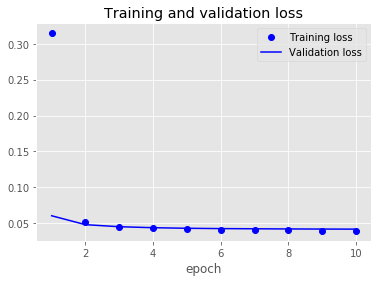

In [33]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

<div style="border: 2px solid red; padding: 10px"> 

***Embedding Layer:***

* An embedding is a vector that act as the "distributed representation" of a particular item (in our case, word).
* Each distinct word should be represented by its own unique embedding. 
* The semantic similarity between the words should correspond to the similarity between their respective embeddings.
* For example, words that are more similar to one another should have similar embeddings.
* Embedding layer converts words into such embedding vectors, which have been pre-learned using some other tasks.

<br>

***Use of Embedding Layer:***

* We need the embedding here to make sure that the prediction for the similar word would be similar as well. 
* Since we are predicting the tag, we know that the tag for the word 'book' would be similar to that of the word 'magazine' but would be very different than the tag for the word 'Thousand'. 
* This is where the embedding comes in. The embedding should be similar to the word 'magazine' but should be much more significantly different than that of the word 'Thousand'.



**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

<div style="border: 2px solid red; padding: 10px"> 

***Param # of Embedding Layer:***

* The number of parameter (Param #) is calculated by multiplying the number of words (`n_words`) with the number of embedding dimension (or the vector length which we want to use to represent the word).
* For each word, we want to represent it with a vector of length $50$ i.e. embidding dimension of $50$. 
* Since there are $35179$ number of words, we would have $35179 * 50 = 1758950\ params$.

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [34]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9409277605244746


In [35]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

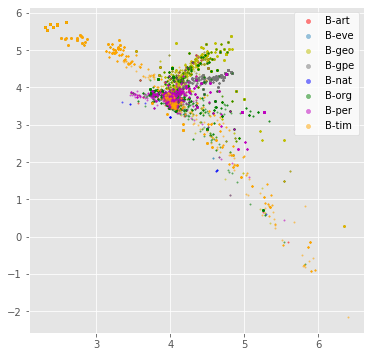

In [36]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [37]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [38]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.9409273720537202


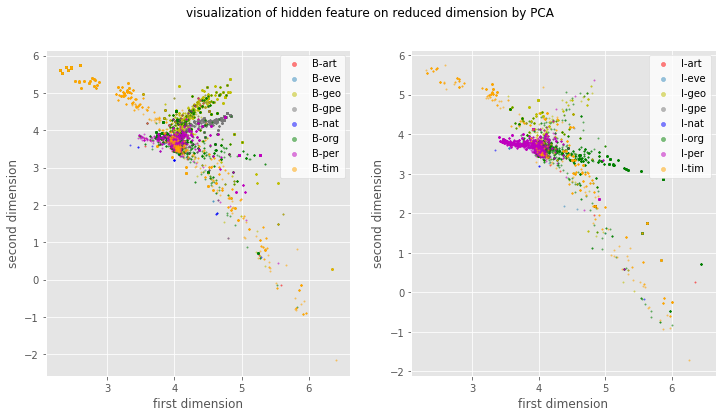

In [39]:
h = get_hidden_output_PCA(FFNN,X_test,y_test,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [40]:
# your code here

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(n_units, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [41]:
# your code here

# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0911 - accuracy: 0.9778 - val_loss: 0.0327 - val_accuracy: 0.9903
Epoch 2/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0295 - accuracy: 0.9912 - val_loss: 0.0286 - val_accuracy: 0.9915
Epoch 3/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0281 - val_accuracy: 0.9916
Epoch 4/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0244 - accuracy: 0.9927 - val_loss: 0.0269 - val_accuracy: 0.9920
Epoch 5/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0268 - val_accuracy: 0.9920
Epoch 6/10
38846/38846 [==============================] - 74s 2ms/sample - loss: 0.0222 - accuracy: 0.9934 - val_loss: 0.0264 - val_accuracy: 0.9921
Epoch 7/10
38846/38846 [==============================] -

In [42]:
# save your mode #
store_keras_model(model, 'model_RNN')

Saved model to disk


In [43]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 100)          15100     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


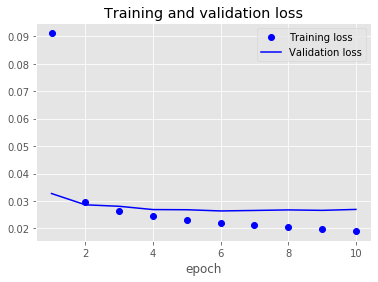

In [44]:
# run this cell to show your results #
plot_training_history(history)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.8390732856040151


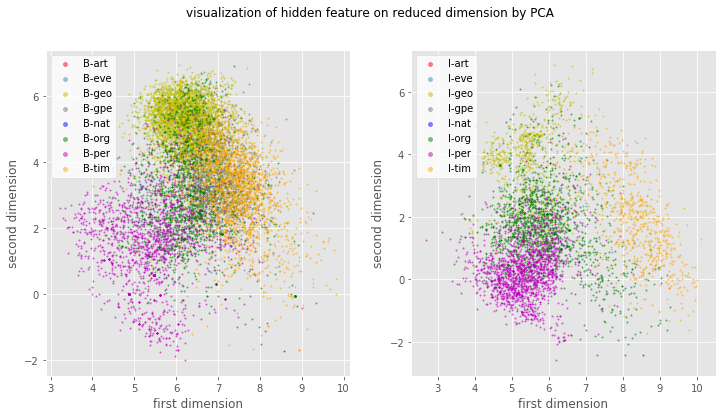

In [45]:
# your code here

RNN = load_keras_model("model_RNN")

h = get_hidden_output_PCA(RNN, X_test, y_test, 2, 100)
visualize_B_I(h)

<div style="border: 2px solid red; padding: 10px"> 
    
***Observations:***
* PCA on hidden layer output is not doing a great job of seperating different tags
* First-two PC's explains 84% of the variance in the data in comparison to 94% of variance explained by first-two PC's in case of FFNN; this maybe due to change in dimensionality of hidden layer i.e. 100 vs 50.
* I-tags are a bit more spread out i.e. dissimilar than B-tags
* Further, when both I-tags and B-tags are combined into single chart, it will be even more difficult to seperate diffierent categories of tags
* Tags like B-per, I-per, I-tim are better seperated than the other tags

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

<div style="border: 2px solid red; padding: 10px"> 

***GRU:***
* Gated Recurrent Unit or GRU is and RNN with a gating mechanism
* GRU, like LSTM, has a forget gate but unlike LSTM, lack output gate, making them simpler than LSTM
* LSTM will always outperform GRU but GRU are less resource intensive i.e. quicker to train

<br>

***GRU vs Simple RNN:***
* Simple RNN lacks gate functionality i.e. no memory is stored, passed on, updated, or forgotten.
* GRU has gate functionality where the memory can be stored, updated, forgotten and passed on.
* The GRU brings more flexibility but at the cost of comlexity and operating costs.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [46]:
# your code here

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(GRU(n_units, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [47]:
# your code here

# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 39s 1ms/sample - loss: 0.0896 - accuracy: 0.9776 - val_loss: 0.0324 - val_accuracy: 0.9904
Epoch 2/10
38846/38846 [==============================] - 36s 932us/sample - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.0283 - val_accuracy: 0.9916
Epoch 3/10
38846/38846 [==============================] - 36s 935us/sample - loss: 0.0260 - accuracy: 0.9923 - val_loss: 0.0273 - val_accuracy: 0.9918
Epoch 4/10
38846/38846 [==============================] - 36s 936us/sample - loss: 0.0242 - accuracy: 0.9928 - val_loss: 0.0264 - val_accuracy: 0.9922
Epoch 5/10
38846/38846 [==============================] - 36s 938us/sample - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.0263 - val_accuracy: 0.9922
Epoch 6/10
38846/38846 [==============================] - 36s 938us/sample - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0256 - val_accuracy: 0.9924
Epoch 7/10
38846/38846 [=======================

In [48]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [49]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


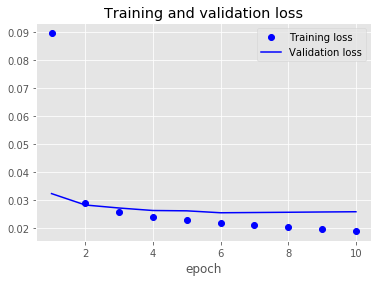

In [50]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.7566368161984738


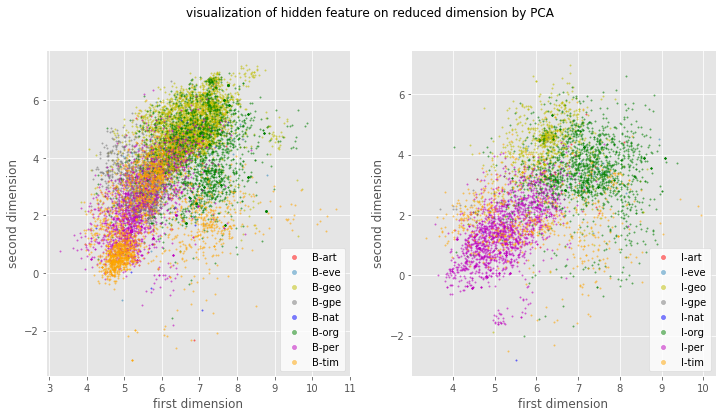

In [51]:
# your code here

GRu = load_keras_model("model_GRU")

h = get_hidden_output_PCA(GRu, X_test, y_test, 2, 100)
visualize_B_I(h)

<div style="border: 2px solid red; padding: 10px"> 

***Observations:***
* PCA on hidden layer output is not doing a great job of seperating different tags in 2-dimensions
* First-two PC's explains 75% of the variance in the data in comparison to 84% for SimpleRNN and 94% for FFNN; this is interesting and warrants further investigation as both Simple RNN and GRU have 100 dimensions in hidden layer. While GRU explains less variance in first-two PC's it has slightly better performance wheh it comes to F1_score.
* The seperation performance is not too different from Simple RNN
* I-tags are a bit more seperated than B-tags
* Further, when both I-tags and B-tags are combined into single chart, it will be even more difficult to seperate diffierent categories of tags

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



<div style="border: 2px solid red; padding: 10px"> 

***Bidirectional GRU vs GRU:***
* GRU analyzes a sequence in just one direction; for example and english sentence is normally analyzed from lest to right by a GRU
* Bidirectional GRU on the other hand analyzes a sequence in both the directions using forward layer and backward layer.
* Bidirectional GRU can capture the contextual information in a better manner than GRU.
* For example, in a sentence "I love apple products", Bidirectional GRU is more likely to figure out that Apple here refers to the company and not the fruit, as it can analyze word "product" that came afterwards to determine the context of the sentence.
* Bidirectional GRU will generally do a better job of translating but come at a cost of computational time.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [52]:
# your code here

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
forward = GRU(n_units, return_sequences=True)
backward = GRU(n_units, return_sequences=True, go_backwards=True)
model.add(Bidirectional(forward, backward_layer=backward))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [53]:
# your code here

# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 72s 2ms/sample - loss: 0.0728 - accuracy: 0.9817 - val_loss: 0.0282 - val_accuracy: 0.9917
Epoch 2/10
38846/38846 [==============================] - 69s 2ms/sample - loss: 0.0242 - accuracy: 0.9929 - val_loss: 0.0239 - val_accuracy: 0.9929
Epoch 3/10
38846/38846 [==============================] - 68s 2ms/sample - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.0228 - val_accuracy: 0.9933
Epoch 4/10
38846/38846 [==============================] - 68s 2ms/sample - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 5/10
38846/38846 [==============================] - 69s 2ms/sample - loss: 0.0176 - accuracy: 0.9948 - val_loss: 0.0218 - val_accuracy: 0.9936
Epoch 6/10
38846/38846 [==============================] - 68s 2ms/sample - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0215 - val_accuracy: 0.9936
Epoch 7/10
38846/38846 [==============================] -

In [54]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [55]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


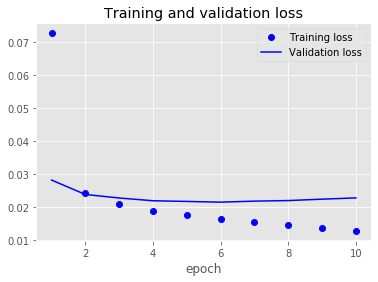

In [56]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.7592999888299015


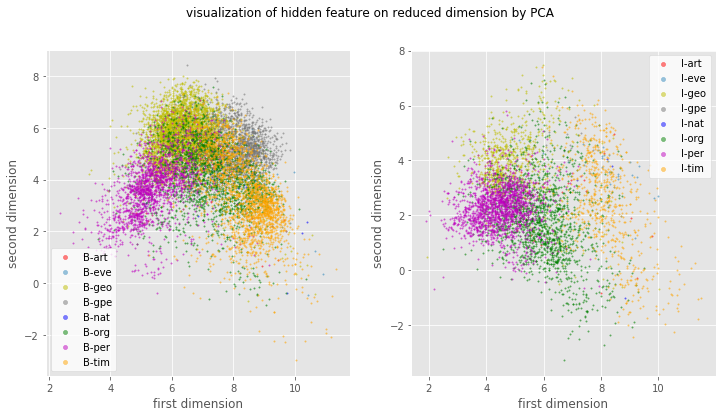

In [57]:
# your code here

BiGRU = load_keras_model("model_BiGRU")

h = get_hidden_output_PCA(BiGRU, X_test, y_test, 2, 200)
visualize_B_I(h)

<div style="border: 2px solid red; padding: 10px"> 

***Observations:***
* PCA on hidden layer output is not doing a good job of seperating different tags in 2-dimensions
* Bidirection GRU's first-two PC's of hidden layer explain about 76% of the variance. This is similar to 75% in case of GRU despite doubling of the dimensions of hidden layer from 100 to 200
* The seperation performance is not too different from Simple RNN or GRU
* I-tags are a bit more seperated than B-tags
* Further, when both I-tags and B-tags are combined into single chart, it will be even more difficult to seperate diffierent categories of tags
* Tags like B-per, I-per, I-org, I-tim are better seperated than the other tags

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [58]:
# your code here

FFNN = load_keras_model("model_FFNN")
RNN = load_keras_model("model_RNN")
GRu = load_keras_model("model_GRU")
BiGRU = load_keras_model("model_BiGRU")

FFNN_pred = FFNN.predict(X_test)
RNN_pred = RNN.predict(X_test)
GRU_pred = GRu.predict(X_test)
BiGRU_pred = BiGRU.predict(X_test)

y_test_flat = y_test.argmax(axis=-1).reshape(-1,1)
baseline_pred = baseline[X_test.flatten()]
FFNN_pred_flat = FFNN_pred.argmax(axis=-1).reshape(-1,1)
RNN_pred_flat = RNN_pred.argmax(axis=-1).reshape(-1,1)
GRU_pred_flat = GRU_pred.argmax(axis=-1).reshape(-1,1)
BiGRU_pred_flat = BiGRU_pred.argmax(axis=-1).reshape(-1,1)

F1_baseline = f1_score(y_test_flat, baseline_pred, average=None)
F1_FFNN = f1_score(y_test_flat, FFNN_pred_flat, average=None)
F1_RNN = f1_score(y_test_flat, RNN_pred_flat, average=None)
F1_GRU = f1_score(y_test_flat, GRU_pred_flat, average=None)
F1_BiGRU = f1_score(y_test_flat, BiGRU_pred_flat, average=None)

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

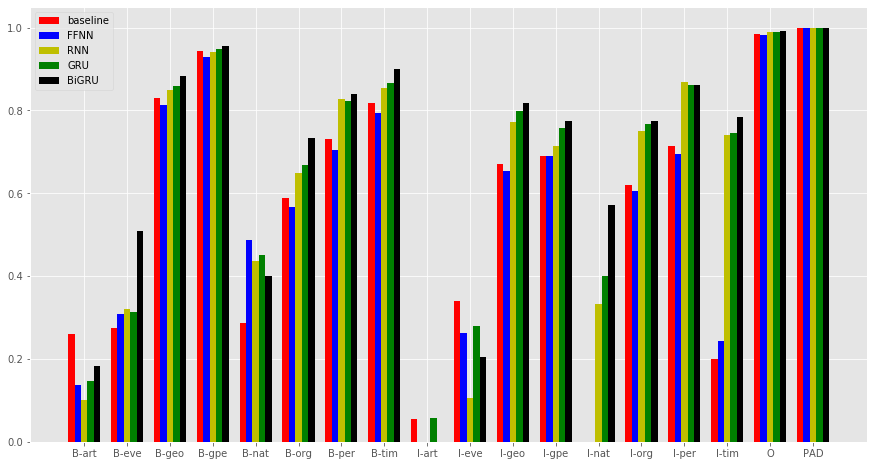

In [59]:
# your code here

F1 = pd.DataFrame(data = {'baseline':F1_baseline, 'FFNN':F1_FFNN, 'RNN':F1_RNN, 'GRU':F1_GRU, 'BiGRU': F1_BiGRU})

# Setting the positions and width for the bars
pos = list(range(len(F1))) 
width = 0.15
fig, ax = plt.subplots(figsize=(15,8))

plt.bar(pos, F1['baseline'],width, color='r', label='baseline') 
plt.bar([p + width for p in pos], F1['FFNN'],width, color='b', label='FFNN') 
plt.bar([p + width*2 for p in pos], F1['RNN'],width, color='y', label='RNN') 
plt.bar([p + width*3 for p in pos], F1['GRU'],width, color='g', label='GRU') 
plt.bar([p + width*4 for p in pos], F1['BiGRU'],width, color='k', label='BiGRU') 

# Set the position of the x ticks
ax.set_xticks([p + 2 * width for p in pos])
ax.set_xticklabels(tags)
plt.legend()
plt.show()

**3.3** Briefly discuss the performance of each model

<div style="border: 2px solid red; padding: 10px"> 

***Performance comparison:***

* For most of the tags, BiGRU seems to perform the best. This difference, however, is not substantial between BiGRU, GRU & SimpleRNN.
* Surprising (or not), the baseline model is not that bad. Even for some of the tags, the baseline model is performing better than the FFNN model. 
* For the most part, the ranking of the model is going from baseline/FFNN, RNN, GRU, and BiGRU. However, for some particular tags (e.g. I-eve), the ranking seems to be reversed. 
* In fact, the baseline model is performing better in case of B-art, I-art and I-eve. 
* As expected, all model are predicting 'PAD' appropriately. 
* Tag 'O' also has high performance from all models, which might be because we have the most data (most words) with tag 'O'. 
* B-art, I-art and I-eve are the 3 tags that have the lowerst performance from all models, which might be because we don't have a lot of data (words) with this tag.
* Baseline model never predicts I-nat correctly and SimpleRNN & BiGRU never predicts I-art correctly.

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

In [60]:
num_tags = y_train.sum(axis=(0,1)).astype(int)
pd.Series(num_tags, index=tags)

B-art        366
B-eve        270
B-geo      33814
B-gpe      14252
B-nat        178
B-org      18162
B-per      15290
B-tim      18233
I-art        269
I-eve        222
I-geo       6652
I-gpe        180
I-nat         47
I-org      15164
I-per      15568
I-tim       5870
O         798876
PAD      3545539
dtype: int64

<div style="border: 2px solid red; padding: 10px"> 

***Lowest F1 Score:***
* I-art and B-art seems to have the lowest score among all models.
* I-eve is also doing fairly poor.
* When we look at training set we realize that B-art, I-art & I-eve had very few training samples, i,e, 366, 269 & 222 respectively.
* Interesting case is I-nat with only 47 training samples; `f1_score` is slightly higher than 0.5.
* 'O' and 'PAD' completely dominates the traning set with total training samples in excess of 4.3 million.


**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [61]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [62]:
# your code here

def tag_model(idx):
    ex = pd.DataFrame()
    ex['Word'] = [idx2word[x] for x in X_test[idx]]
    ex['y_true'] = [idx2tag[y.argmax()] for y in y_test[idx]]
    ex['baseline'] = [idx2tag[baseline[y]] for y in X_test[idx]]
    ex['model_FFNN'] = [idx2tag[y.argmax()] for y in FFNN_pred[idx]]
    ex['model_RNN'] = [idx2tag[y.argmax()] for y in RNN_pred[idx]]
    ex['model_GRU'] = [idx2tag[y.argmax()] for y in GRU_pred[idx]]
    ex['model_BiGRU'] = [idx2tag[y.argmax()] for y in BiGRU_pred[0]] 
    return ex.style.apply(highlight_errors, axis=1)

In [63]:
# your code here

id_Bart = tag2idx['B-art']
id_Iart = tag2idx['I-art']
Bart = False
Iart = False
for sentence in range(X_test.shape[0]):
    for word in range(X_test.shape[1]):
        if (y_test[sentence][word].argmax() == id_Bart):
            Bart = True
        if (y_test[sentence][word].argmax() == id_Iart):
            Iart = True
    if Bart and Iart:
        df = tag_model(sentence)
        break

In [64]:
# your code here

display(df)

,Word,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,Speaking,O,O,O,O,O,B-per
1,on,O,O,O,O,O,I-per
2,the,O,O,O,O,O,O
3,U.S.,B-geo,B-geo,B-geo,B-geo,B-geo,O
4,television,O,O,O,O,O,O
5,news,O,O,O,O,O,O
6,program,O,O,O,O,O,O
7,60,B-art,O,O,O,O,B-gpe
8,Minutes,I-art,O,O,O,O,O
9,",",O,O,O,O,O,O


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [65]:
# your code here

def stratify_data(min_group):
    stratify_list = []
    
    for tag in min_group:
        tag_set = set([int(str(v).split(" ")[-1]) for v in data[data.Tag==tag]["Sentence #"].values])
        stratify_list.append(tag_set)
    
    for i, tag_set in enumerate(stratify_list):
        stratify_list[i] = stratify_list[i]-stratify_list[i-1]
    
    union = set()
    for i in stratify_list:
        union = union|i
    
    dif = set(range(len(X)))-union
    train_idx = []
    test_idx = []
    
    for tag_set in stratify_list:
        tr,te = train_test_split(list(tag_set),test_size=0.1)
        train_idx += (tr)
        test_idx += (te)
        
    tr,te = train_test_split(list(dif),test_size=0.1)
    train_idx += (tr)
    test_idx += (te)
    X_tr = X[train_idx]
    X_te = X[test_idx]
    y_tr = y[train_idx]
    y_te = y[test_idx]
    y_tr = np.array([to_categorical(i, num_classes=n_tags) for i in y_tr])
    y_te = np.array([to_categorical(i, num_classes=n_tags) for i in y_te])
    
    return (X_tr, X_te, y_tr, y_te), union


base = data.Tag.value_counts()[1]


def boost_weight(min_group,union):
    new_weight = {}
    for tag in min_group:
        new_weight[tag] = base//data.Tag.value_counts()[tag]*10
    
    weight = np.ones((len(X_train), X.shape[1]))
    for i in range(len(X_train)):
        for tag in min_group:
            if i in union:
                weight[i,:] = (new_weight[tag])
                break
                
    return weight


target_group = ["I-nat", "I-gpe", "B-eve", "I-tim", "I-geo"]
(X_train, X_te, y_train, y_te), union = stratify_data(target_group)


sample_weight = boost_weight(target_group,union)

In [66]:
n_units = 100
drop_rate = 0.3
dim_embed = 50


output_bias = np.log(y_train.sum(axis=(0,1))/
                     (y_train.sum() - y_train.sum(axis=(0,1)))
                    ).reshape(-1,1)
output_bias = tf.keras.initializers.Constant(output_bias)


class_weights = y_train.sum() / (2 * y_train.sum(axis=(0,1)))
class_weights = tf.constant(class_weights)


def weighted_cross_entropy(y_true,y_pred):
    loss = tf.cast(-y_true, dtype=tf.float32) * tf.cast(class_weights, dtype=tf.float32)
    loss = loss * tf.math.log(tf.cast(y_pred, dtype=tf.float32)) 
    loss = tf.math.reduce_sum(loss)
    return loss


optimizer = "rmsprop"
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss = "categorical_crossentropy"
metrics = ["accuracy"]
metrics = [tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'), 
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
          ]


batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [67]:
# your code here

model = Sequential()

model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))

forward = LSTM(n_units, return_sequences=True)
backward = LSTM(n_units, return_sequences=True, go_backwards=True)
model.add(Bidirectional(forward, backward_layer=backward, merge_mode='sum'))

forward2 = LSTM(n_units, return_sequences=True)
backward2 = LSTM(n_units, return_sequences=True, go_backwards=True)
model.add(Bidirectional(forward2, backward_layer=backward2, merge_mode='sum'))

model.add(TimeDistributed(Dense(n_tags, activation="softmax",
                                bias_initializer=output_bias)))

# Compile model
model.compile(optimizer=optimizer, loss=loss, sample_weight_mode='temporal', metrics=metrics)

In [68]:
# your code here

# Train model
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    sample_weight=sample_weight,
                    validation_split=validation_split, 
                    verbose=verbose
                   )

Train on 38906 samples, validate on 4323 samples
Epoch 1/10
38906/38906 [==============================] - 141s 4ms/sample - loss: 154.0785 - tp: 3919329.0000 - fp: 63809.0000 - tn: 68721984.0000 - fn: 126895.0000 - accuracy: 0.9743 - val_loss: 79.9981 - val_tp: 440091.0000 - val_fp: 3122.0000 - val_tn: 7639942.0000 - val_fn: 9501.0000 - val_accuracy: 0.9852
Epoch 2/10
38906/38906 [==============================] - 147s 4ms/sample - loss: 55.8496 - tp: 3991558.0000 - fp: 26682.0000 - tn: 68759112.0000 - fn: 54666.0000 - accuracy: 0.9893 - val_loss: 49.7491 - val_tp: 444615.0000 - val_fp: 2875.0000 - val_tn: 7640189.0000 - val_fn: 4977.0000 - val_accuracy: 0.9909
Epoch 3/10
38906/38906 [==============================] - 147s 4ms/sample - loss: 36.2614 - tp: 4010355.0000 - fp: 23580.0000 - tn: 68762248.0000 - fn: 35869.0000 - accuracy: 0.9924 - val_loss: 47.3846 - val_tp: 445246.0000 - val_fp: 2976.0000 - val_tn: 7640088.0000 - val_fn: 4346.0000 - val_accuracy: 0.9915
Epoch 4/10
38906/38

In [69]:
# your code here

# save your model #
store_keras_model(model, 'model_final')

Saved model to disk


In [70]:
# your code here

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 100)          120800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 104, 100)          160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 104, 18)           1818      
Total params: 2,042,368
Trainable params: 2,042,368
Non-trainable params: 0
_________________________________________________________________
None


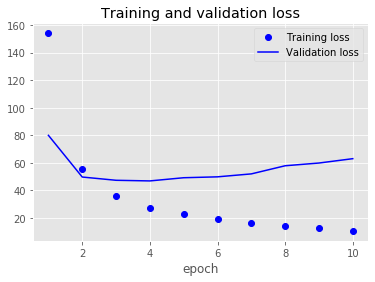

In [71]:
# your code here

plot_training_history(history)

Variance explained by PCA: 0.862046376799865


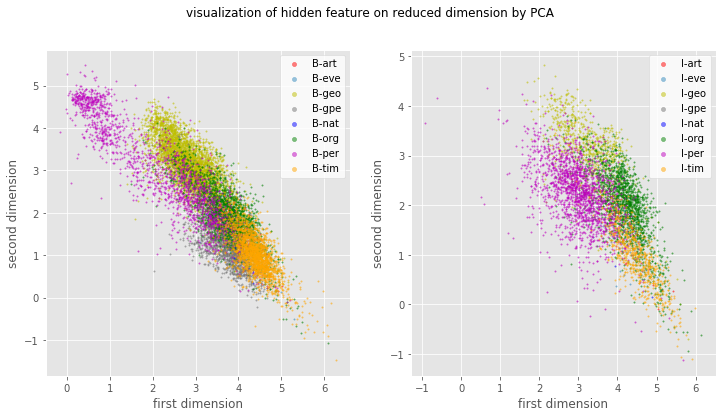

In [72]:
# your code here

final = load_keras_model("model_final")

h = get_hidden_output_PCA(final, X_test, y_test, 2, 100)
visualize_B_I(h)

In [73]:
# your code here

final = load_keras_model("model_final")
final_pred = final.predict(X_test)
final_pred_flat = final_pred.argmax(axis=-1).reshape(-1,1)

y_test_flat = y_test.argmax(axis=-1).reshape(-1,1)

F1_final = f1_score(y_test_flat, final_pred_flat, average=None)

In [74]:
F1_final

array([0.2       , 0.44117647, 0.8953078 , 0.95122709, 0.29411765,
       0.79033054, 0.87784177, 0.90194198, 0.37837838, 0.41666667,
       0.83948959, 0.75862069, 0.33333333, 0.82398801, 0.90443987,
       0.77315208, 0.99293724, 0.99999111])

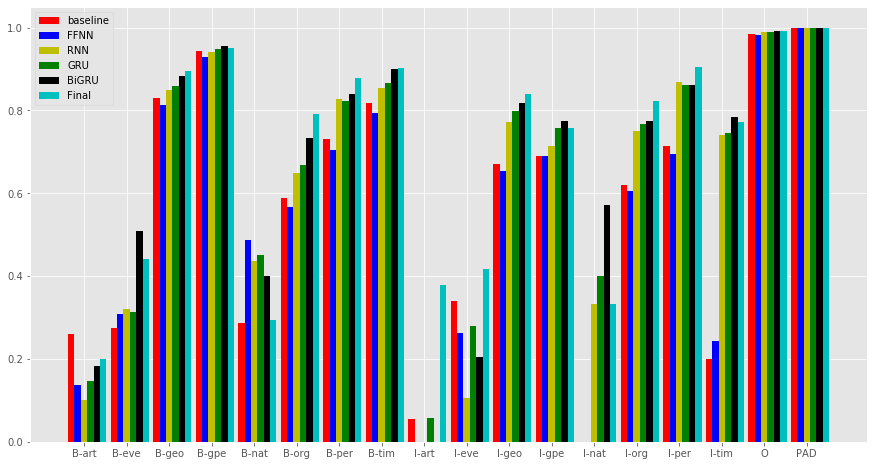

In [75]:
# your code here

F1 = pd.DataFrame(data = {'baseline':F1_baseline, 'FFNN':F1_FFNN, 'RNN':F1_RNN, 
                          'GRU':F1_GRU, 'BiGRU': F1_BiGRU, 'Final': F1_final})

# Setting the positions and width for the bars
pos = list(range(len(F1))) 
width = 0.15
fig, ax = plt.subplots(figsize=(15,8))

plt.bar(pos, F1['baseline'],width, color='r', label='baseline') 
plt.bar([p + width for p in pos], F1['FFNN'],width, color='b', label='FFNN') 
plt.bar([p + width*2 for p in pos], F1['RNN'],width, color='y', label='RNN') 
plt.bar([p + width*3 for p in pos], F1['GRU'],width, color='g', label='GRU') 
plt.bar([p + width*4 for p in pos], F1['BiGRU'],width, color='k', label='BiGRU') 
plt.bar([p + width*5 for p in pos], F1['Final'],width, color='c', label='Final') 

# Set the position of the x ticks
ax.set_xticks([p + 2 * width for p in pos])
ax.set_xticklabels(tags)
plt.legend()
plt.show()

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

<div style="border: 2px solid red; padding: 10px"> 

***Number of Tags with F1 Score > 0.8:***
* 9 tags have `f1_score > 0.80`
* In addition 3 tags have `f1_score > 0.70`

<br>

***Model Design Choices:***
* Loss function
* Sample Weights
* `bias_initializer':

<br>

***Effectiveness of Model Design Choices:***
* Loss function





# End of Assignment